# Financial Exploratory Analysis

This exploratory analysis seeks to better understand issues and relationships surrounding financial data. The data sources are from two categories: public domain financial data and textual data. 

## Get S&P500 stocker tickers and related data

In [1]:
import bs4 as bs
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import style
from mpl_finance import candlestick_ohlc
import numpy as np
import os
import pandas as pd
import pandas_datareader.data as web
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pickle
import requests
from collections import Counter
from sklearn import svm, model_selection as cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from urllib.request import urlretrieve

style.use('ggplot')

In [2]:
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[1].text
        mapping = str.maketrans(".","-")
        ticker = ticker.translate(mapping)
        tickers.append(ticker)
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    return tickers

In [3]:
#save_sp500_tickers()

In [4]:
# save_sp500_tickers()
def get_data_from_yahoo(reload_sp500=False):  # (reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2010, 1, 1)
    end = dt.datetime.now()
    for ticker in tickers:
        # just in case your connection breaks, we'd like to save our progress!
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker, 'yahoo', start, end)
            df.reset_index(inplace=True)
            df.set_index("Date", inplace=True)
            #df = df.drop("Symbol", axis=1)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))

In [5]:
#get_data_from_yahoo(reload_sp500=True)

Already have MMM
Already have ABT
Already have ABBV
Already have ABMD
Already have ACN
Already have ATVI
Already have ADBE
Already have AMD
Already have AAP
Already have AES
Already have AMG
Already have AFL
Already have A
Already have APD
Already have AKAM
Already have ALK
Already have ALB
Already have ARE
Already have ALXN
Already have ALGN
Already have ALLE
Already have AGN
Already have ADS
Already have LNT
Already have ALL
Already have GOOGL
Already have GOOG
Already have MO
Already have AMZN
Already have AEE
Already have AAL
Already have AEP
Already have AXP
Already have AIG
Already have AMT
Already have AWK
Already have AMP
Already have ABC
Already have AME
Already have AMGN
Already have APH
Already have APC
Already have ADI
Already have ANSS
Already have ANTM
Already have AON
Already have AOS
Already have APA
Already have AIV
Already have AAPL
Already have AMAT
Already have APTV
Already have ADM
Already have ARNC
Already have ANET
Already have AJG
Already have AIZ
Already have A

In [6]:
def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()

    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)

        df.rename(columns={'Adj Close': ticker}, inplace=True)
        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)

        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')

        if count % 10 == 0:
            print(count)
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')

In [7]:
#compile_data()

## Exploratory analysis for relationships in the data

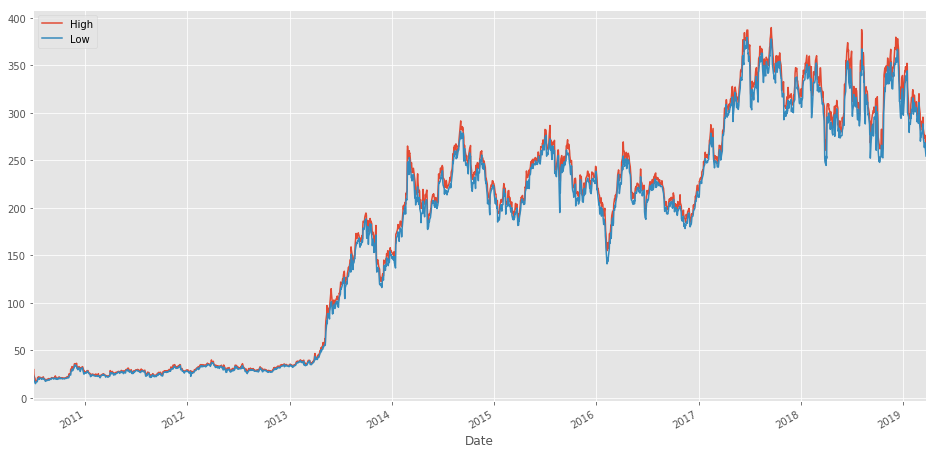

In [8]:
# Plot various stats from selected ticker data
#
start = dt.datetime(2010,1,1)
end = dt.datetime.now()
df = web.DataReader('TSLA', 'yahoo', start, end)

#df.head()
df.to_csv('tsla.csv')
df = pd.read_csv('tsla.csv', parse_dates=True, index_col=0)

plt.rcParams['figure.figsize'] = [16, 8]

#df['Adj Close'].plot()
df[['High','Low']].plot()

In [9]:
# Create 100 day rolling average data as a column in dataset
#
df['100ma'] = df['Adj Close'].rolling(window=100, min_periods=0).mean()
df.tail()  # examine the new '100ma' column data

,High,Low,Open,Close,Volume,Adj Close,100ma
Date,,,,,,,
2019-03-19,273.299988,263.459991,267.500000,267.470001,11800600,267.470001,321.974200
2019-03-20,274.970001,266.299988,269.690002,273.600006,6908200,273.600006,321.768800
2019-03-21,276.450012,268.450012,272.600006,274.019989,5947100,274.019989,321.624000
2019-03-22,272.799988,264.000000,272.579987,264.529999,8732600,264.529999,321.120700
2019-03-25,263.179993,254.460007,259.709991,261.430115,7553432,261.430115,320.426001


<BarContainer object of 2199 artists>

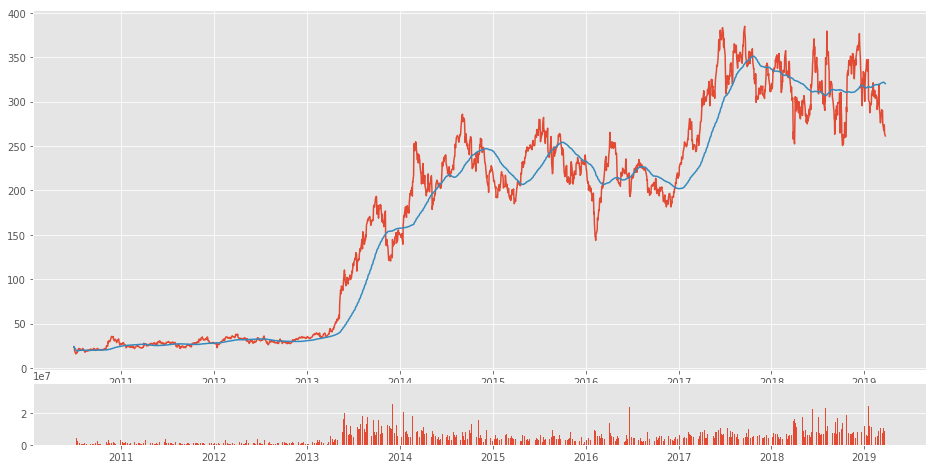

In [10]:
# Configure plot
plt.rcParams['figure.figsize'] = [16, 8]

ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)  # share the X axis for zooming :)

ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100ma'])
ax2.bar(df.index, df['Volume'])

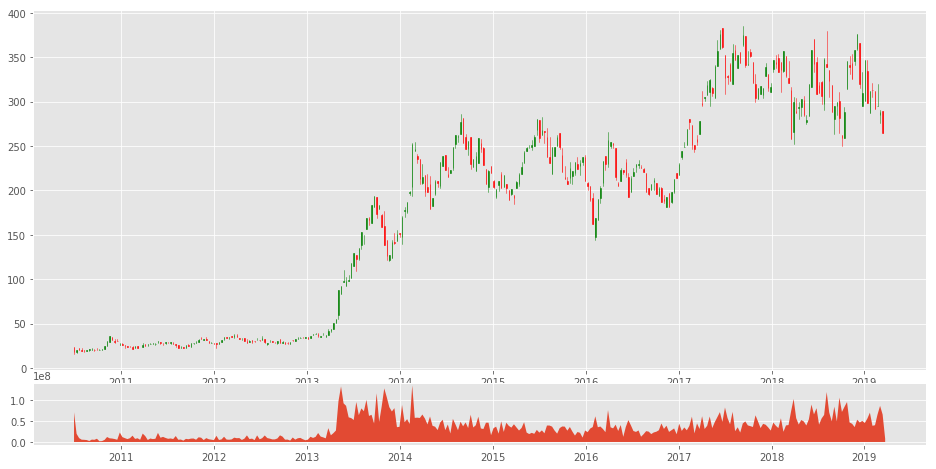

In [11]:
# Candlestick plot vs Volume

df = pd.read_csv('tsla.csv', parse_dates=True, index_col=0)
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_volume = df['Volume'].resample('10D').sum()
df_ohlc = df_ohlc.reset_index()
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)

plt.rcParams['figure.figsize'] = [16, 8]
fig = plt.figure()
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)  # share the X axis for zooming :)
ax1.xaxis_date()

candlestick_ohlc(ax1, df_ohlc.values, width=2, colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)
plt.show()

In [12]:
# Visualize the correlation of ticker 'Adj Close' data - the plot is massive
def visualize_data_correlation():
    df = pd.read_csv('sp500_joined_closes.csv')
    df_corr = df.corr()
    #print(df_corr.head())
    df_corr.to_csv('sp500corr.csv')
    data1 = df_corr.values
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)

    heatmap1 = ax1.pcolor(data1, cmap=plt.cm.RdYlGn)
    fig1.colorbar(heatmap1)

    ax1.set_xticks(np.arange(data1.shape[1]) + 0.5, minor=False)
    ax1.set_yticks(np.arange(data1.shape[0]) + 0.5, minor=False)
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap1.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()


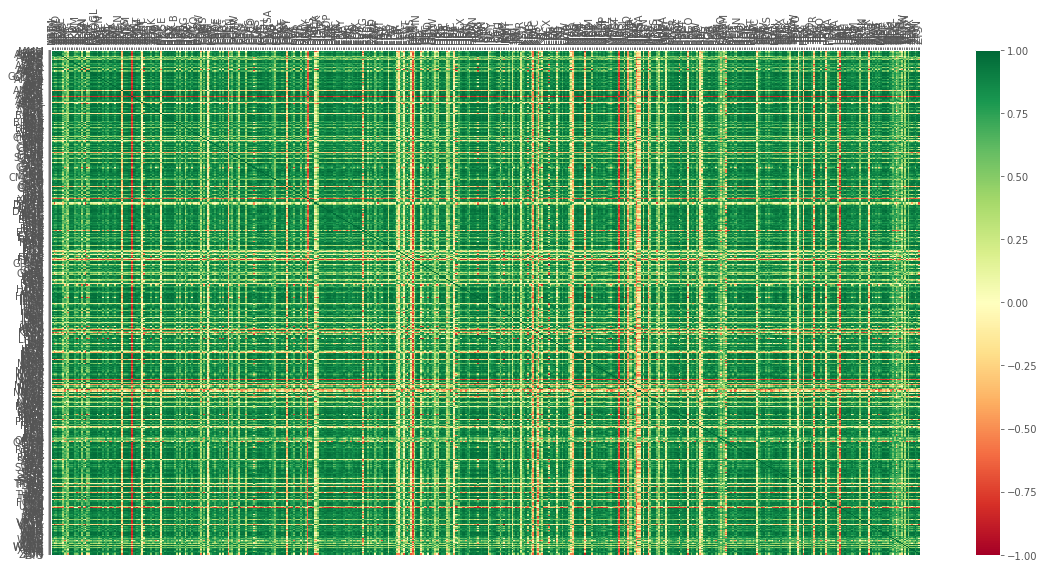

In [13]:
visualize_data_correlation()

## Begin ML

Convert data to featuresets, map them to defined labels.

This exploration analyses ticker price changes for all companies and map the results to buy, sell or hold labels. The trigger for each label will be a declared percentage of price change. Results are analyzed to determine actual spread, predicted spread and accuracy of the prediction.

In [14]:
# Preprocessing for ML modeling

def process_data_for_labels(ticker):
    """blah"""
    predict_days = 7  # predict future price in days
    df = pd.read_csv('sp500_joined_closes.csv', index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    for i in range(1, predict_days+1):
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
    
    df.fillna(0, inplace=True)
    return tickers, df

In [15]:
#process_data_for_labels('BAC')

In [16]:
# Function that creates our 'buy-sell-hold' labels
def buy_sell_hold(*args):
    """blah"""
    cols = [c for c in args]
    requirement = 0.02  # 2% change fires buy or sell trigger
    for col in cols:
        if col > requirement:
            return 1  # buy
        if col < -requirement:
            return -1  # sell
    return 0

In [17]:
# Create dataset and 'target' column (label) from any ticker
def extract_bsh_featuresets(ticker):
    """blah"""
    predict_days = 7
    tickers, df = process_data_for_labels(ticker)
    df['{}_target'.format(ticker)] = list(map( buy_sell_hold,
                                               df['{}_1d'.format(ticker)],
                                               df['{}_2d'.format(ticker)],
                                               df['{}_3d'.format(ticker)],
                                               df['{}_4d'.format(ticker)],
                                               df['{}_5d'.format(ticker)],
                                               df['{}_6d'.format(ticker)],
                                               df['{}_7d'.format(ticker)]
                                               ))

    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    
    print(ticker)
    print('Data spread: ', Counter(str_vals))
    
    # Clean up missing data replacing gaps with 0, replace infinte values to NaNs, then drop the NaNs 
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    df_vals = df[[ticker for ticker in tickers]].pct_change()  # normalize the values
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    # X are featuresets, y are labels
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    
    return X, y, df

In [18]:
#extract_bsh_featuresets('AAPL')

In [19]:
# ML Classifier
def do_ml(ticker):
    """blah"""
    X, y, df = extract_bsh_featuresets(ticker)
    
    # Shuffle the data and create training and testing samples ensuring we do not test the algorithm on same data
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)
    
    #clf = neighbors.KNeighborsClassifier()  # select KNearestNeighbor
    clf = VotingClassifier([('lsvc', svm.LinearSVC(max_iter=100000)),
                             ('knn', neighbors.KNeighborsClassifier()),
                             ('rfor', RandomForestClassifier(n_estimators=100))])
    
    clf.fit(X_train, y_train)  # X_train is the % change for all the tickers, y is the target: 0, 1 or -1
    confidence = clf.score(X_test, y_test)
    predictions = clf.predict(X_test)
    
    print('Predicted spread: ', Counter(predictions))
    print('Model accuracy: ', confidence)
    print()
    
    return confidence
    

In [20]:
#do_ml('XOM')
#do_ml('BAC')

In [21]:
# Process all the tickers
from statistics import mean

with open("sp500tickers.pickle", "rb") as f:
    tickers = pickle.load(f)
    
accuracies = []
for count, ticker in enumerate(tickers):
    if count % 10 == 0:
        print(count)
    
    accuracy = do_ml(ticker)
    accuracies.append(accuracy)
    print("{} Model accuracy: {}. Average accuracy: {}".format(ticker,accuracy,mean(accuracies)))
    print()
    

0
MMM
Data spread:  Counter({'0': 878, '1': 848, '-1': 595})
Predicted spread:  Counter({0: 330, 1: 166, -1: 85})
Model accuracy:  0.40619621342512907

MMM Model accuracy: 0.40619621342512907. Average accuracy: 0.40619621342512907

ABT
Data spread:  Counter({'1': 924, '0': 753, '-1': 644})
Predicted spread:  Counter({1: 339, -1: 125, 0: 117})
Model accuracy:  0.36660929432013767

ABT Model accuracy: 0.36660929432013767. Average accuracy: 0.38640275387263334

ABBV
Data spread:  Counter({'0': 1030, '1': 749, '-1': 542})
Predicted spread:  Counter({0: 263, -1: 159, 1: 157})
Model accuracy:  0.5267702936096719

ABBV Model accuracy: 0.5267702936096719. Average accuracy: 0.43319193378497955

ABMD
Data spread:  Counter({'1': 1268, '-1': 913, '0': 140})
Predicted spread:  Counter({1: 484, -1: 97})
Model accuracy:  0.5163511187607573

ABMD Model accuracy: 0.5163511187607573. Average accuracy: 0.453981730028924

ACN
Data spread:  Counter({'1': 969, '0': 696, '-1': 656})
Predicted spread:  Counte

Predicted spread:  Counter({1: 469, -1: 111, 0: 1})
Model accuracy:  0.46471600688468157

AMP Model accuracy: 0.46471600688468157. Average accuracy: 0.43342184630654573

ABC
Data spread:  Counter({'1': 999, '-1': 725, '0': 597})
Predicted spread:  Counter({1: 430, -1: 124, 0: 27})
Model accuracy:  0.4044750430292599

ABC Model accuracy: 0.4044750430292599. Average accuracy: 0.4326600883255645

AME
Data spread:  Counter({'1': 947, '-1': 727, '0': 647})
Predicted spread:  Counter({1: 318, -1: 178, 0: 85})
Model accuracy:  0.37865748709122204

AME Model accuracy: 0.37865748709122204. Average accuracy: 0.43127540624263266

AMGN
Data spread:  Counter({'1': 983, '-1': 822, '0': 516})
Predicted spread:  Counter({1: 333, -1: 239, 0: 9})
Model accuracy:  0.39070567986230637

AMGN Model accuracy: 0.39070567986230637. Average accuracy: 0.4302611630831245

40
APH
Data spread:  Counter({'1': 940, '0': 721, '-1': 660})
Predicted spread:  Counter({1: 301, -1: 158, 0: 122})
Model accuracy:  0.39070567

Predicted spread:  Counter({1: 411, -1: 170})
Model accuracy:  0.459552495697074

BBY Model accuracy: 0.459552495697074. Average accuracy: 0.425752613487726

BIIB
Data spread:  Counter({'1': 1088, '-1': 938, '0': 295})
Predicted spread:  Counter({1: 311, -1: 270})
Model accuracy:  0.46987951807228917

BIIB Model accuracy: 0.46987951807228917. Average accuracy: 0.426348923009139

BLK
Data spread:  Counter({'1': 997, '-1': 836, '0': 488})
Predicted spread:  Counter({1: 300, -1: 267, 0: 14})
Model accuracy:  0.4199655765920826

BLK Model accuracy: 0.4199655765920826. Average accuracy: 0.42626381172357825

HRB
Data spread:  Counter({'1': 1045, '-1': 913, '0': 363})
Predicted spread:  Counter({1: 348, -1: 233})
Model accuracy:  0.41480206540447506

HRB Model accuracy: 0.41480206540447506. Average accuracy: 0.42611299927201113

BA
Data spread:  Counter({'1': 1076, '-1': 756, '0': 489})
Predicted spread:  Counter({1: 501, -1: 77, 0: 3})
Model accuracy:  0.4440619621342513

BA Model accuracy: 

CMG
Data spread:  Counter({'1': 1078, '-1': 887, '0': 356})
Predicted spread:  Counter({1: 326, -1: 255})
Model accuracy:  0.4457831325301205

CMG Model accuracy: 0.4457831325301205. Average accuracy: 0.42589299243169926

110
CB
Data spread:  Counter({'0': 906, '1': 807, '-1': 608})
Predicted spread:  Counter({0: 316, -1: 166, 1: 99})
Model accuracy:  0.3459552495697074

CB Model accuracy: 0.3459552495697074. Average accuracy: 0.42517283258609573

CHD
Data spread:  Counter({'0': 916, '1': 842, '-1': 563})
Predicted spread:  Counter({0: 391, 1: 122, -1: 68})
Model accuracy:  0.43717728055077454

CHD Model accuracy: 0.43717728055077454. Average accuracy: 0.4252800151572089

CI
Data spread:  Counter({'1': 1110, '-1': 786, '0': 425})
Predicted spread:  Counter({1: 463, -1: 118})
Model accuracy:  0.44922547332185886

CI Model accuracy: 0.44922547332185886. Average accuracy: 0.4254919218666306

XEC
Data spread:  Counter({'1': 1128, '-1': 1063, '0': 130})
Predicted spread:  Counter({-1: 318, 

DVA
Data spread:  Counter({'1': 871, '-1': 766, '0': 684})
Predicted spread:  Counter({1: 271, -1: 219, 0: 91})
Model accuracy:  0.37005163511187605

DVA Model accuracy: 0.37005163511187605. Average accuracy: 0.4255332157485978

DE
Data spread:  Counter({'1': 1004, '-1': 808, '0': 509})
Predicted spread:  Counter({1: 393, -1: 182, 0: 6})
Model accuracy:  0.40963855421686746

DE Model accuracy: 0.40963855421686746. Average accuracy: 0.42542508879940233

DAL
Data spread:  Counter({'1': 1157, '-1': 1015, '0': 149})
Predicted spread:  Counter({1: 326, -1: 255})
Model accuracy:  0.5025817555938038

DAL Model accuracy: 0.5025817555938038. Average accuracy: 0.42594641762909424

XRAY
Data spread:  Counter({'1': 937, '-1': 762, '0': 622})
Predicted spread:  Counter({1: 326, -1: 173, 0: 82})
Model accuracy:  0.3683304647160069

XRAY Model accuracy: 0.3683304647160069. Average accuracy: 0.4255597333813554

DVN
Data spread:  Counter({'-1': 1077, '1': 1048, '0': 196})
Predicted spread:  Counter({-1

EVRG
Data spread:  Counter({'0': 2189, '1': 86, '-1': 46})
Predicted spread:  Counter({0: 579})
Model accuracy:  0.9430051813471503

EVRG Model accuracy: 0.9430051813471503. Average accuracy: 0.42739083229091657

ES
Data spread:  Counter({'1': 887, '0': 860, '-1': 574})
Predicted spread:  Counter({0: 321, 1: 182, -1: 78})
Model accuracy:  0.4027538726333907

ES Model accuracy: 0.4027538726333907. Average accuracy: 0.4272562040960667

RE
Data spread:  Counter({'0': 839, '1': 821, '-1': 661})
Predicted spread:  Counter({0: 319, 1: 141, -1: 121})
Model accuracy:  0.4044750430292599

RE Model accuracy: 0.4044750430292599. Average accuracy: 0.42713239343809495

EXC
Data spread:  Counter({'1': 913, '-1': 722, '0': 686})
Predicted spread:  Counter({1: 256, -1: 241, 0: 84})
Model accuracy:  0.36316695352839934

EXC Model accuracy: 0.36316695352839934. Average accuracy: 0.42678663430344793

EXPE
Data spread:  Counter({'1': 1137, '-1': 954, '0': 230})
Predicted spread:  Counter({1: 394, -1: 187}

Predicted spread:  Counter({-1: 326, 1: 246, 0: 7})
Model accuracy:  0.40414507772020725

GM Model accuracy: 0.40414507772020725. Average accuracy: 0.42753003530720757

GPC
Data spread:  Counter({'1': 913, '-1': 708, '0': 700})
Predicted spread:  Counter({1: 245, 0: 174, -1: 162})
Model accuracy:  0.35628227194492257

GPC Model accuracy: 0.35628227194492257. Average accuracy: 0.42720470305441177

GILD
Data spread:  Counter({'1': 1050, '-1': 924, '0': 347})
Predicted spread:  Counter({1: 349, -1: 232})
Model accuracy:  0.4664371772805508

GILD Model accuracy: 0.4664371772805508. Average accuracy: 0.42738303248271237

220
GPN
Data spread:  Counter({'1': 1071, '-1': 754, '0': 496})
Predicted spread:  Counter({1: 461, -1: 118, 0: 2})
Model accuracy:  0.4423407917383821

GPN Model accuracy: 0.4423407917383821. Average accuracy: 0.4274507146512901

GS
Data spread:  Counter({'1': 1025, '-1': 900, '0': 396})
Predicted spread:  Counter({1: 350, -1: 230, 0: 1})
Model accuracy:  0.430292598967297

Predicted spread:  Counter({1: 287, -1: 241, 0: 53})
Model accuracy:  0.3683304647160069

ICE Model accuracy: 0.3683304647160069. Average accuracy: 0.42992496564661853

IBM
Data spread:  Counter({'0': 835, '1': 789, '-1': 697})
Predicted spread:  Counter({-1: 232, 0: 219, 1: 130})
Model accuracy:  0.3648881239242685

IBM Model accuracy: 0.3648881239242685. Average accuracy: 0.4296699192084916

INCY
Data spread:  Counter({'1': 1188, '-1': 1065, '0': 68})
Predicted spread:  Counter({1: 325, -1: 256})
Model accuracy:  0.5146299483648882

INCY Model accuracy: 0.5146299483648882. Average accuracy: 0.43000179432238383

IP
Data spread:  Counter({'1': 1040, '-1': 904, '0': 377})
Predicted spread:  Counter({1: 430, -1: 149, 0: 2})
Model accuracy:  0.4406196213425129

IP Model accuracy: 0.4406196213425129. Average accuracy: 0.43004310882440766

IPG
Data spread:  Counter({'1': 995, '-1': 900, '0': 426})
Predicted spread:  Counter({1: 298, -1: 283})
Model accuracy:  0.4027538726333907

IPG Model a

LEG
Data spread:  Counter({'1': 975, '-1': 797, '0': 549})
Predicted spread:  Counter({1: 300, -1: 248, 0: 33})
Model accuracy:  0.3993115318416523

LEG Model accuracy: 0.3993115318416523. Average accuracy: 0.43302691990948355

LEN
Data spread:  Counter({'1': 1113, '-1': 1018, '0': 190})
Predicted spread:  Counter({1: 377, -1: 204})
Model accuracy:  0.4784853700516351

LEN Model accuracy: 0.4784853700516351. Average accuracy: 0.43318259953325805

LLY
Data spread:  Counter({'1': 945, '0': 743, '-1': 633})
Predicted spread:  Counter({1: 336, -1: 150, 0: 95})
Model accuracy:  0.37521514629948366

LLY Model accuracy: 0.37521514629948366. Average accuracy: 0.4329847583959414

LNC
Data spread:  Counter({'1': 1126, '-1': 895, '0': 300})
Predicted spread:  Counter({1: 439, -1: 142})
Model accuracy:  0.46987951807228917

LNC Model accuracy: 0.46987951807228917. Average accuracy: 0.4331102507757929

LIN
Data spread:  Counter({'0': 2135, '1': 97, '-1': 89})
Predicted spread:  Counter({0: 579})
Mo

MNST
Data spread:  Counter({'1': 1084, '-1': 866, '0': 371})
Predicted spread:  Counter({1: 424, -1: 156, 0: 1})
Model accuracy:  0.4406196213425129

MNST Model accuracy: 0.4406196213425129. Average accuracy: 0.43306878688875333

MCO
Data spread:  Counter({'1': 1039, '-1': 755, '0': 527})
Predicted spread:  Counter({1: 410, -1: 157, 0: 14})
Model accuracy:  0.43373493975903615

MCO Model accuracy: 0.43373493975903615. Average accuracy: 0.43307081166951406

MS
Data spread:  Counter({'1': 1090, '-1': 964, '0': 267})
Predicted spread:  Counter({1: 400, -1: 181})
Model accuracy:  0.4836488812392427

MS Model accuracy: 0.4836488812392427. Average accuracy: 0.4332240785469981

330
MOS
Data spread:  Counter({'1': 1058, '-1': 1026, '0': 237})
Predicted spread:  Counter({1: 295, -1: 286})
Model accuracy:  0.4440619621342513

MOS Model accuracy: 0.4440619621342513. Average accuracy: 0.4332568213977149

MSI
Data spread:  Counter({'1': 939, '0': 702, '-1': 680})
Predicted spread:  Counter({1: 355,

Predicted spread:  Counter({1: 435, -1: 142, 0: 4})
Model accuracy:  0.4027538726333907

PH Model accuracy: 0.4027538726333907. Average accuracy: 0.43290809461410956

PAYX
Data spread:  Counter({'1': 895, '0': 809, '-1': 617})
Predicted spread:  Counter({0: 257, 1: 226, -1: 98})
Model accuracy:  0.3993115318416523

PAYX Model accuracy: 0.3993115318416523. Average accuracy: 0.4328160492366508

PYPL
Data spread:  Counter({'0': 1512, '1': 481, '-1': 328})
Predicted spread:  Counter({0: 529, -1: 37, 1: 13})
Model accuracy:  0.6770293609671848

PYPL Model accuracy: 0.6770293609671848. Average accuracy: 0.43348329872225333

PNR
Data spread:  Counter({'1': 1028, '-1': 891, '0': 402})
Predicted spread:  Counter({1: 320, -1: 254, 0: 7})
Model accuracy:  0.4010327022375215

PNR Model accuracy: 0.4010327022375215. Average accuracy: 0.43339487747842576

PBCT
Data spread:  Counter({'1': 811, '0': 770, '-1': 740})
Predicted spread:  Counter({0: 265, -1: 160, 1: 156})
Model accuracy:  0.3683304647160

RSG
Data spread:  Counter({'0': 975, '1': 798, '-1': 548})
Predicted spread:  Counter({0: 385, 1: 122, -1: 74})
Model accuracy:  0.40619621342512907

RSG Model accuracy: 0.40619621342512907. Average accuracy: 0.4352471524653109

RMD
Data spread:  Counter({'1': 1061, '-1': 782, '0': 478})
Predicted spread:  Counter({1: 425, -1: 154, 0: 2})
Model accuracy:  0.4406196213425129

RMD Model accuracy: 0.4406196213425129. Average accuracy: 0.43526051681575173

RHI
Data spread:  Counter({'1': 1133, '-1': 838, '0': 350})
Predicted spread:  Counter({1: 494, -1: 87})
Model accuracy:  0.4475043029259897

RHI Model accuracy: 0.4475043029259897. Average accuracy: 0.435290898419003

ROK
Data spread:  Counter({'1': 1064, '-1': 828, '0': 429})
Predicted spread:  Counter({1: 452, -1: 129})
Model accuracy:  0.4354561101549053

ROK Model accuracy: 0.4354561101549053. Average accuracy: 0.4352913073589433

ROL
Data spread:  Counter({'1': 1001, '0': 660, '-1': 660})
Predicted spread:  Counter({1: 410, -1: 120

Predicted spread:  Counter({1: 382, -1: 193, 0: 6})
Model accuracy:  0.43029259896729777

TEL Model accuracy: 0.43029259896729777. Average accuracy: 0.43527340679609516

FTI
Data spread:  Counter({'1': 1089, '-1': 1032, '0': 200})
Predicted spread:  Counter({-1: 292, 1: 289})
Model accuracy:  0.4664371772805508

FTI Model accuracy: 0.4664371772805508. Average accuracy: 0.43534455695701857

TFX
Data spread:  Counter({'1': 984, '-1': 689, '0': 648})
Predicted spread:  Counter({1: 462, -1: 78, 0: 41})
Model accuracy:  0.3855421686746988

TFX Model accuracy: 0.3855421686746988. Average accuracy: 0.4352311118812046

TXN
Data spread:  Counter({'1': 1084, '-1': 761, '0': 476})
Predicted spread:  Counter({1: 426, -1: 151, 0: 4})
Model accuracy:  0.42168674698795183

TXN Model accuracy: 0.42168674698795183. Average accuracy: 0.43520032923372

440
TXT
Data spread:  Counter({'1': 1060, '-1': 950, '0': 311})
Predicted spread:  Counter({1: 398, -1: 183})
Model accuracy:  0.42168674698795183

TXT Mo

VZ
Data spread:  Counter({'1': 836, '0': 800, '-1': 685})
Predicted spread:  Counter({0: 225, -1: 199, 1: 157})
Model accuracy:  0.3769363166953528

VZ Model accuracy: 0.3769363166953528. Average accuracy: 0.4348050693885279

VRTX
Data spread:  Counter({'1': 1120, '-1': 1091, '0': 110})
Predicted spread:  Counter({1: 340, -1: 241})
Model accuracy:  0.47676419965576594

VRTX Model accuracy: 0.47676419965576594. Average accuracy: 0.4348934043996169

VIAB
Data spread:  Counter({'1': 1047, '-1': 962, '0': 312})
Predicted spread:  Counter({-1: 335, 1: 246})
Model accuracy:  0.43717728055077454

VIAB Model accuracy: 0.43717728055077454. Average accuracy: 0.43489820245875793

V
Data spread:  Counter({'1': 998, '-1': 676, '0': 647})
Predicted spread:  Counter({1: 331, -1: 172, 0: 78})
Model accuracy:  0.3683304647160069

V Model accuracy: 0.3683304647160069. Average accuracy: 0.43475864745300796

VNO
Data spread:  Counter({'1': 949, '-1': 754, '0': 618})
Predicted spread:  Counter({1: 311, -1: